# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

utils.set_seed(0)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate synthetic data

In [ ]:
from VAETransformer_FCGPFA import get_K
### Generate data
torch.manual_seed(0)
np.random.seed(0)

MAX_FIRING_RATE = 10
gt_neuron_params = {'baseline_fr':0.05, 'ntrial':2000, 'narea':2, 'nneuron_area':50, 
                    'nt':250, 'npadding':50}
gt_latent_params = {'sigma2':0.5, 'nlatent':2, 'offset':0.0, 'L':150}
coupling_filter_params = {'peaks_max':5, 'num':3, 'nonlinear':0.5}
nfactor_baseline = gt_latent_params['nlatent']
connections = [{'send':0, 'receive':1, 
                'strength': np.array([[1,0.0],[0,0.0],[0,0.0]])/5,
                'nneuron_involved': 10}]

ntrial = gt_neuron_params['ntrial']
nneuron = gt_neuron_params['narea']*gt_neuron_params['nneuron_area']
nneuron_area = gt_neuron_params['nneuron_area']
narea = gt_neuron_params['narea']
basis_coupling = GLM.make_pillow_basis(**coupling_filter_params)
max_histories, nbasis = basis_coupling.shape
nt = gt_neuron_params['nt'] + gt_neuron_params['npadding']
nfactor_coupling_tot = sum([conn['strength'].shape[1] for conn in connections])

baseline_mat = np.ones((nt, nneuron, ntrial))*np.log(gt_neuron_params['baseline_fr'])
spikes = np.zeros((nt, nneuron, ntrial))
log_firing_rate_rcd = np.zeros((nt, nneuron, ntrial))
factor_coupling = np.zeros((nt, nfactor_coupling_tot, ntrial))

# Prepare loading_mat_baseline
loading_mat_baseline_list = [np.zeros((nneuron_area, nfactor_baseline)) for _ in range(narea)]
for jarea in range(narea):
    loading_mat_baseline_list[jarea] = (
        np.random.uniform(low=-1, high=1, size=(nneuron_area, nfactor_baseline))
    )

# Prepare baseline_mat
for jarea in range(narea):
    K_gt = get_K(nt=nt, L=gt_latent_params['L'], sigma2=gt_latent_params['sigma2'])
    factor_baseline = np.random.multivariate_normal(
        np.zeros(nt), K_gt, (ntrial, nfactor_baseline)
    ).transpose(2, 1, 0) # nt x nlatent x ntrial
    baseline_mat[:, jarea*nneuron_area:(jarea+1)*nneuron_area, :] += (
        np.einsum('nf, tfm -> tnm', loading_mat_baseline_list[jarea], factor_baseline)
    )

# Prepare coupling_mat
readin_mat_coupling = np.zeros((nneuron, nfactor_coupling_tot))
coupling_mat = np.zeros((max_histories, nneuron, nfactor_coupling_tot))
loading_mat_coupling = np.zeros((nneuron, nfactor_coupling_tot))
nfactor_coupling_counter = 0
for i, connection in enumerate(connections):
    nneuron_involved = connection['nneuron_involved']
    nfactor_coupling = connection['strength'].shape[1]
    temp = np.random.uniform(low=0.8, high=1.2, size=(nneuron_involved, nfactor_coupling))
    temp /= np.linalg.norm(temp, axis=0)[np.newaxis, :]
    readin_mat_coupling[
        connection['send']*nneuron_area:connection['send']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = temp
    coupling_mat[
        :, 
        connection['send']*nneuron_area:connection['send']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = (basis_coupling @ connection['strength'])[::-1, np.newaxis, :]
    coupling_mat *= readin_mat_coupling[np.newaxis, :, :]
    temp = np.random.uniform(low=0.8, high=1.2, size=(nneuron_involved, nfactor_coupling))
    temp /= np.linalg.norm(temp, axis=0)[np.newaxis, :]
    loading_mat_coupling[
        connection['receive']*nneuron_area:connection['receive']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = temp
    nfactor_coupling_counter += nfactor_coupling

# Generate spikes
for itrial in tqdm(range(ntrial)):
    spikes_single_trial = np.zeros((nt, nneuron, 1))
    log_firing_rate = copy.copy(baseline_mat[:,:,itrial:itrial+1])
    spikes_single_trial[0,:,0] = np.random.poisson(np.exp(log_firing_rate[0,:, 0]))

    for t in range(1, nt):
        nhistories = min(t, max_histories)
        factor_coupling_single = (coupling_mat[-nhistories:, :, :] \
                * spikes_single_trial[(t-nhistories):(t), :, :]).sum(axis=(0, 1))
        factor_coupling[t,:,itrial] = factor_coupling_single
        log_firing_rate[t,:,0] += (loading_mat_coupling @ factor_coupling_single[:, np.newaxis]).squeeze()
        log_firing_rate[t,:,0] = np.minimum(log_firing_rate[t,:,0], MAX_FIRING_RATE)
        spikes_single_trial[t,:,0] = np.random.poisson(np.exp(log_firing_rate[t,:,0]))
        # spikes_single_trial[t,:,0] = np.exp(log_firing_rate[t,:,0])

    log_firing_rate = log_firing_rate.squeeze()
    spikes_single_trial = spikes_single_trial.squeeze()
    spikes[:, :, itrial] = spikes_single_trial
    log_firing_rate_rcd[:, :, itrial] = log_firing_rate


spikes_area = [spikes[:,iarea*nneuron_area:(iarea+1)*nneuron_area,:] for iarea in range(narea)]

100%|██████████| 2000/2000 [00:19<00:00, 101.03it/s]


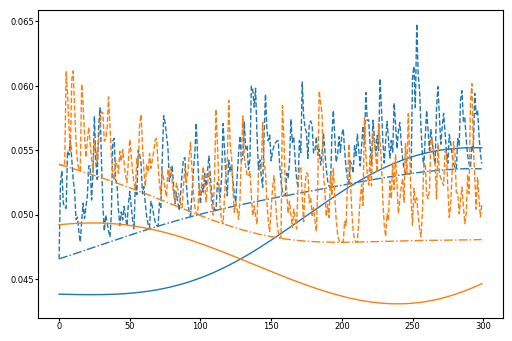

In [189]:
plt.figure(figsize=(6,4))
trials_to_plot = 2

for trial in range(trials_to_plot):  # Plot first 20 trials
    # Get mean across neurons for this trial
    pop1_mean = np.exp(log_firing_rate_rcd[:,:gt_neuron_params["nneuron_area"],trial].mean(axis=1))
    pop2_mean = np.exp(log_firing_rate_rcd[:,gt_neuron_params["nneuron_area"]:,trial].mean(axis=1))
    pop1_baseline = np.exp(baseline_mat[:,gt_neuron_params["nneuron_area"]:,trial].mean(axis=1))
    line, = plt.plot(pop1_mean)
    plt.plot(pop2_mean, "--", color=line.get_color())
    plt.plot(pop1_baseline, "-.", color=line.get_color())


Text(0.5, 1.0, 'Spike raster for neuron 55')

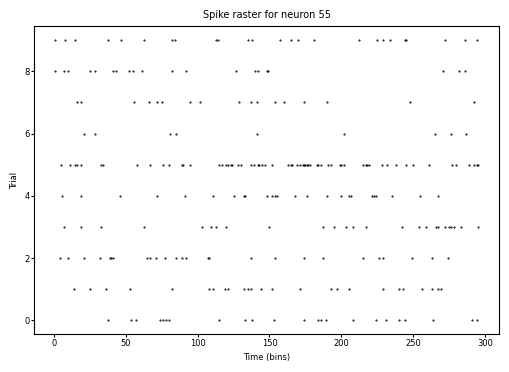

In [190]:
# Plot raster for one example neuron
neuron_idx = 55  # Choose first neuron
plt.figure(figsize=(6,4))
for trial in range(10):  # Plot first 200 trials
    spike_times = np.where(spikes[:,neuron_idx,trial])[0]
    plt.plot(spike_times, trial*np.ones_like(spike_times), '.', markersize=1, color='black')
plt.xlabel('Time (bins)')
plt.ylabel('Trial')
plt.title(f'Spike raster for neuron {neuron_idx}')


In [191]:
nneuron = spikes.shape[1]//2

synthetic_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:nneuron,:], spikes[:,nneuron:,:]],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

# Train a model

Current problems:
- Not stable! Run the code multiple times, the results are different. **Solved by temporal correlation penalty**
- The coupling effect is not capturing what it should capture. ** **

Things I want to try:
- see if the baseline looks good. **YES**
- I want to get a clear two modes in t-sne plot, since the ground truth is two modes. **YES**
- Play with hyperparameters, see what appect the results. **lr is still very important. Epoch is also important.**
- Try make coupling effect weaker by setting initial value to be around zero. I don't want to see the coupling effect being too strong. **can be done by frozing Transformer encoder**
- See how would overlapping penalty affect the results. overlapping_penalty=None: 0.2283
overlapping_penalty=1e0: 0.2289. **but overlapping penalty makes coupling very small**
- Try penalty temporal correlation. **Works great!**
- Try not frozing Transformer encoder. **(a different dataset than the previous one) 0.2300 vs 0.2308. So Yes, frozing encoder**
- Try cls token. **No, will lead to mode collapse**
- Get a set of hyperparameters that works in both conn=0.0 and conn=0.01. ** **
- compare with no f(z,t) but just f(t). The coupling effect should be much stronger. 


- I don't know why the first element in both sending and receiving weights are much larger than the rest.


In [192]:
FIT_THE_BASELINE_MODEL = False

# data_to_use = cross_session_dataloader
data_to_use = synthetic_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

params = {
    # B-spline basis
    'num_B_spline_basis': 10,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 8,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 1,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 5,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': False,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Penalty settings
    'penalty_smoothing_spline': 1e4,
    'penalty_effect_overlapping': None, 
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)

if FIT_THE_BASELINE_MODEL:
    # Baseline model: no trial-varying stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )

else:
    # First step: train the model with a trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )
    # Second step: train the model with a trial-varying stimulus effect
    # trainer.make_optimizer(frozen_params=['sti_readout'])
    trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )

    trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
    # trainer.make_optimizer(frozen_params=[])
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )



/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 10, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 8, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': False, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 10000.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 204.90it/s]


Epoch 1/200, Train Loss: 1.0513, Test Loss: 0.8735


100%|██████████| 4/4 [00:00<00:00, 151.44it/s]


Epoch 2/200, Train Loss: 0.7180, Test Loss: 0.5607


100%|██████████| 4/4 [00:00<00:00, 203.68it/s]


Epoch 3/200, Train Loss: 0.4535, Test Loss: 0.3623


100%|██████████| 4/4 [00:00<00:00, 190.86it/s]


Epoch 4/200, Train Loss: 0.3145, Test Loss: 0.2810


100%|██████████| 4/4 [00:00<00:00, 207.29it/s]


Epoch 5/200, Train Loss: 0.2634, Test Loss: 0.2536


100%|██████████| 4/4 [00:00<00:00, 217.56it/s]


Epoch 6/200, Train Loss: 0.2458, Test Loss: 0.2433


100%|██████████| 4/4 [00:00<00:00, 189.33it/s]


Epoch 7/200, Train Loss: 0.2387, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 231.18it/s]


Epoch 8/200, Train Loss: 0.2355, Test Loss: 0.2365


100%|██████████| 4/4 [00:00<00:00, 191.14it/s]


Epoch 9/200, Train Loss: 0.2338, Test Loss: 0.2353


100%|██████████| 4/4 [00:00<00:00, 195.45it/s]


Epoch 10/200, Train Loss: 0.2328, Test Loss: 0.2346


100%|██████████| 4/4 [00:00<00:00, 205.50it/s]


Epoch 11/200, Train Loss: 0.2323, Test Loss: 0.2341


100%|██████████| 4/4 [00:00<00:00, 209.61it/s]


Epoch 12/200, Train Loss: 0.2320, Test Loss: 0.2339


100%|██████████| 4/4 [00:00<00:00, 204.34it/s]


Epoch 13/200, Train Loss: 0.2318, Test Loss: 0.2337


100%|██████████| 4/4 [00:00<00:00, 202.13it/s]


Epoch 14/200, Train Loss: 0.2317, Test Loss: 0.2336


100%|██████████| 4/4 [00:00<00:00, 206.75it/s]


Epoch 15/200, Train Loss: 0.2316, Test Loss: 0.2336


100%|██████████| 4/4 [00:00<00:00, 202.70it/s]


Epoch 16/200, Train Loss: 0.2315, Test Loss: 0.2335


100%|██████████| 4/4 [00:00<00:00, 184.49it/s]


Epoch 17/200, Train Loss: 0.2315, Test Loss: 0.2335


100%|██████████| 4/4 [00:00<00:00, 208.90it/s]


Epoch 18/200, Train Loss: 0.2315, Test Loss: 0.2335


100%|██████████| 4/4 [00:00<00:00, 195.90it/s]


Epoch 19/200, Train Loss: 0.2315, Test Loss: 0.2335


100%|██████████| 4/4 [00:00<00:00, 218.40it/s]


Epoch 20/200, Train Loss: 0.2315, Test Loss: 0.2335
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2335


100%|██████████| 4/4 [00:00<00:00, 198.28it/s]


Epoch 21/200, Train Loss: 0.2314, Test Loss: 0.2335


100%|██████████| 4/4 [00:00<00:00, 202.10it/s]


Epoch 22/200, Train Loss: 0.2314, Test Loss: 0.2335
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2335


100%|██████████| 4/4 [00:00<00:00, 203.75it/s]


Epoch 23/200, Train Loss: 0.2314, Test Loss: 0.2335
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2335


100%|██████████| 4/4 [00:00<00:00, 196.81it/s]
/home/qix/FC-GPFA/model_trainer.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(te

Epoch 24/200, Train Loss: 0.2314, Test Loss: 0.2335
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2335
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 10, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 8, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': False, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 10000.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_m

100%|██████████| 4/4 [00:00<00:00, 171.18it/s]


Epoch 1/200, Train Loss: 0.2373, Test Loss: 0.2345


100%|██████████| 4/4 [00:00<00:00, 160.62it/s]


Epoch 2/200, Train Loss: 0.2317, Test Loss: 0.2332


100%|██████████| 4/4 [00:00<00:00, 117.85it/s]


Epoch 3/200, Train Loss: 0.2312, Test Loss: 0.2331


100%|██████████| 4/4 [00:00<00:00, 165.93it/s]


Epoch 4/200, Train Loss: 0.2311, Test Loss: 0.2330


100%|██████████| 4/4 [00:00<00:00, 153.17it/s]


Epoch 5/200, Train Loss: 0.2311, Test Loss: 0.2330


100%|██████████| 4/4 [00:00<00:00, 171.31it/s]


Epoch 6/200, Train Loss: 0.2311, Test Loss: 0.2330


100%|██████████| 4/4 [00:00<00:00, 172.95it/s]


Epoch 7/200, Train Loss: 0.2310, Test Loss: 0.2330


100%|██████████| 4/4 [00:00<00:00, 162.88it/s]


Epoch 8/200, Train Loss: 0.2310, Test Loss: 0.2330


100%|██████████| 4/4 [00:00<00:00, 160.21it/s]


Epoch 9/200, Train Loss: 0.2310, Test Loss: 0.2329


100%|██████████| 4/4 [00:00<00:00, 163.71it/s]


Epoch 10/200, Train Loss: 0.2310, Test Loss: 0.2329


100%|██████████| 4/4 [00:00<00:00, 158.03it/s]


Epoch 11/200, Train Loss: 0.2309, Test Loss: 0.2329


100%|██████████| 4/4 [00:00<00:00, 161.86it/s]


Epoch 12/200, Train Loss: 0.2309, Test Loss: 0.2328


100%|██████████| 4/4 [00:00<00:00, 166.01it/s]


Epoch 13/200, Train Loss: 0.2308, Test Loss: 0.2327


100%|██████████| 4/4 [00:00<00:00, 159.14it/s]


Epoch 14/200, Train Loss: 0.2307, Test Loss: 0.2326


100%|██████████| 4/4 [00:00<00:00, 158.32it/s]


Epoch 15/200, Train Loss: 0.2307, Test Loss: 0.2326


100%|██████████| 4/4 [00:00<00:00, 123.51it/s]


Epoch 16/200, Train Loss: 0.2306, Test Loss: 0.2325


100%|██████████| 4/4 [00:00<00:00, 163.05it/s]


Epoch 17/200, Train Loss: 0.2306, Test Loss: 0.2325


100%|██████████| 4/4 [00:00<00:00, 175.88it/s]


Epoch 18/200, Train Loss: 0.2305, Test Loss: 0.2324


100%|██████████| 4/4 [00:00<00:00, 179.01it/s]


Epoch 19/200, Train Loss: 0.2305, Test Loss: 0.2323


100%|██████████| 4/4 [00:00<00:00, 136.99it/s]


Epoch 20/200, Train Loss: 0.2304, Test Loss: 0.2323


100%|██████████| 4/4 [00:00<00:00, 161.73it/s]


Epoch 21/200, Train Loss: 0.2304, Test Loss: 0.2322


100%|██████████| 4/4 [00:00<00:00, 171.88it/s]


Epoch 22/200, Train Loss: 0.2303, Test Loss: 0.2321


100%|██████████| 4/4 [00:00<00:00, 169.90it/s]


Epoch 23/200, Train Loss: 0.2302, Test Loss: 0.2320


100%|██████████| 4/4 [00:00<00:00, 162.22it/s]


Epoch 24/200, Train Loss: 0.2301, Test Loss: 0.2320


100%|██████████| 4/4 [00:00<00:00, 167.67it/s]


Epoch 25/200, Train Loss: 0.2301, Test Loss: 0.2319


100%|██████████| 4/4 [00:00<00:00, 167.20it/s]


Epoch 26/200, Train Loss: 0.2300, Test Loss: 0.2317


100%|██████████| 4/4 [00:00<00:00, 175.41it/s]


Epoch 27/200, Train Loss: 0.2299, Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 149.77it/s]


Epoch 28/200, Train Loss: 0.2297, Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 163.07it/s]


Epoch 29/200, Train Loss: 0.2296, Test Loss: 0.2314


100%|██████████| 4/4 [00:00<00:00, 163.89it/s]


Epoch 30/200, Train Loss: 0.2295, Test Loss: 0.2313


100%|██████████| 4/4 [00:00<00:00, 167.89it/s]


Epoch 31/200, Train Loss: 0.2294, Test Loss: 0.2311


100%|██████████| 4/4 [00:00<00:00, 160.07it/s]


Epoch 32/200, Train Loss: 0.2292, Test Loss: 0.2309


100%|██████████| 4/4 [00:00<00:00, 161.44it/s]


Epoch 33/200, Train Loss: 0.2290, Test Loss: 0.2307


100%|██████████| 4/4 [00:00<00:00, 165.39it/s]


Epoch 34/200, Train Loss: 0.2289, Test Loss: 0.2305


100%|██████████| 4/4 [00:00<00:00, 168.28it/s]


Epoch 35/200, Train Loss: 0.2287, Test Loss: 0.2303


100%|██████████| 4/4 [00:00<00:00, 163.82it/s]


Epoch 36/200, Train Loss: 0.2285, Test Loss: 0.2301


100%|██████████| 4/4 [00:00<00:00, 160.40it/s]


Epoch 37/200, Train Loss: 0.2283, Test Loss: 0.2299


100%|██████████| 4/4 [00:00<00:00, 169.26it/s]


Epoch 38/200, Train Loss: 0.2281, Test Loss: 0.2297


100%|██████████| 4/4 [00:00<00:00, 166.36it/s]


Epoch 39/200, Train Loss: 0.2279, Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 167.98it/s]


Epoch 40/200, Train Loss: 0.2277, Test Loss: 0.2292


100%|██████████| 4/4 [00:00<00:00, 157.47it/s]


Epoch 41/200, Train Loss: 0.2275, Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 169.34it/s]


Epoch 42/200, Train Loss: 0.2273, Test Loss: 0.2287


100%|██████████| 4/4 [00:00<00:00, 163.80it/s]


Epoch 43/200, Train Loss: 0.2271, Test Loss: 0.2285


100%|██████████| 4/4 [00:00<00:00, 163.19it/s]


Epoch 44/200, Train Loss: 0.2269, Test Loss: 0.2283


100%|██████████| 4/4 [00:00<00:00, 166.00it/s]


Epoch 45/200, Train Loss: 0.2267, Test Loss: 0.2282


100%|██████████| 4/4 [00:00<00:00, 166.39it/s]


Epoch 46/200, Train Loss: 0.2266, Test Loss: 0.2281


100%|██████████| 4/4 [00:00<00:00, 169.39it/s]


Epoch 47/200, Train Loss: 0.2265, Test Loss: 0.2279


100%|██████████| 4/4 [00:00<00:00, 157.02it/s]


Epoch 48/200, Train Loss: 0.2264, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 161.13it/s]


Epoch 49/200, Train Loss: 0.2263, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 147.90it/s]


Epoch 50/200, Train Loss: 0.2263, Test Loss: 0.2278
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 155.03it/s]


Epoch 51/200, Train Loss: 0.2263, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 163.88it/s]


Epoch 52/200, Train Loss: 0.2263, Test Loss: 0.2276


100%|██████████| 4/4 [00:00<00:00, 134.87it/s]


Epoch 53/200, Train Loss: 0.2261, Test Loss: 0.2275


100%|██████████| 4/4 [00:00<00:00, 165.50it/s]


Epoch 54/200, Train Loss: 0.2260, Test Loss: 0.2275


100%|██████████| 4/4 [00:00<00:00, 162.12it/s]


Epoch 55/200, Train Loss: 0.2260, Test Loss: 0.2275


100%|██████████| 4/4 [00:00<00:00, 172.27it/s]


Epoch 56/200, Train Loss: 0.2260, Test Loss: 0.2274


100%|██████████| 4/4 [00:00<00:00, 150.86it/s]


Epoch 57/200, Train Loss: 0.2259, Test Loss: 0.2274


100%|██████████| 4/4 [00:00<00:00, 162.11it/s]


Epoch 58/200, Train Loss: 0.2259, Test Loss: 0.2274


100%|██████████| 4/4 [00:00<00:00, 168.08it/s]


Epoch 59/200, Train Loss: 0.2259, Test Loss: 0.2274


100%|██████████| 4/4 [00:00<00:00, 169.38it/s]


Epoch 60/200, Train Loss: 0.2259, Test Loss: 0.2274


100%|██████████| 4/4 [00:00<00:00, 162.34it/s]


Epoch 61/200, Train Loss: 0.2259, Test Loss: 0.2274


100%|██████████| 4/4 [00:00<00:00, 169.67it/s]


Epoch 62/200, Train Loss: 0.2259, Test Loss: 0.2274


100%|██████████| 4/4 [00:00<00:00, 173.73it/s]


Epoch 63/200, Train Loss: 0.2259, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 161.80it/s]


Epoch 64/200, Train Loss: 0.2259, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 143.26it/s]


Epoch 65/200, Train Loss: 0.2259, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 173.22it/s]


Epoch 66/200, Train Loss: 0.2259, Test Loss: 0.2273
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 162.55it/s]


Epoch 67/200, Train Loss: 0.2259, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 157.47it/s]


Epoch 68/200, Train Loss: 0.2258, Test Loss: 0.2273
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 169.41it/s]


Epoch 69/200, Train Loss: 0.2258, Test Loss: 0.2273
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 168.32it/s]


Epoch 70/200, Train Loss: 0.2259, Test Loss: 0.2274
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2273
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 10, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 8, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': False, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 10000.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_m

100%|██████████| 4/4 [00:00<00:00, 138.17it/s]


Epoch 1/200, Train Loss: 0.2259, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 148.56it/s]


Epoch 2/200, Train Loss: 0.2259, Test Loss: 0.2273
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 146.38it/s]


Epoch 3/200, Train Loss: 0.2258, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 147.15it/s]


Epoch 4/200, Train Loss: 0.2257, Test Loss: 0.2271


100%|██████████| 4/4 [00:00<00:00, 152.67it/s]


Epoch 5/200, Train Loss: 0.2256, Test Loss: 0.2271


100%|██████████| 4/4 [00:00<00:00, 144.60it/s]


Epoch 6/200, Train Loss: 0.2256, Test Loss: 0.2271
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2271


100%|██████████| 4/4 [00:00<00:00, 154.81it/s]


Epoch 7/200, Train Loss: 0.2256, Test Loss: 0.2271
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2271


100%|██████████| 4/4 [00:00<00:00, 146.12it/s]


Epoch 8/200, Train Loss: 0.2256, Test Loss: 0.2271


100%|██████████| 4/4 [00:00<00:00, 123.96it/s]


Epoch 9/200, Train Loss: 0.2256, Test Loss: 0.2271
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2271


100%|██████████| 4/4 [00:00<00:00, 136.64it/s]


Epoch 10/200, Train Loss: 0.2256, Test Loss: 0.2271
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2271


100%|██████████| 4/4 [00:00<00:00, 148.57it/s]

Epoch 11/200, Train Loss: 0.2256, Test Loss: 0.2271
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2271
Early stopping triggered.


In [221]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader

###
trainer.model.normalize_coupling_coefficients()
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")

100%|██████████| 7/7 [00:00<00:00, 114.52it/s]

Test loss: 0.2255399252782736
Test loss baseline: 0.2313052412131778


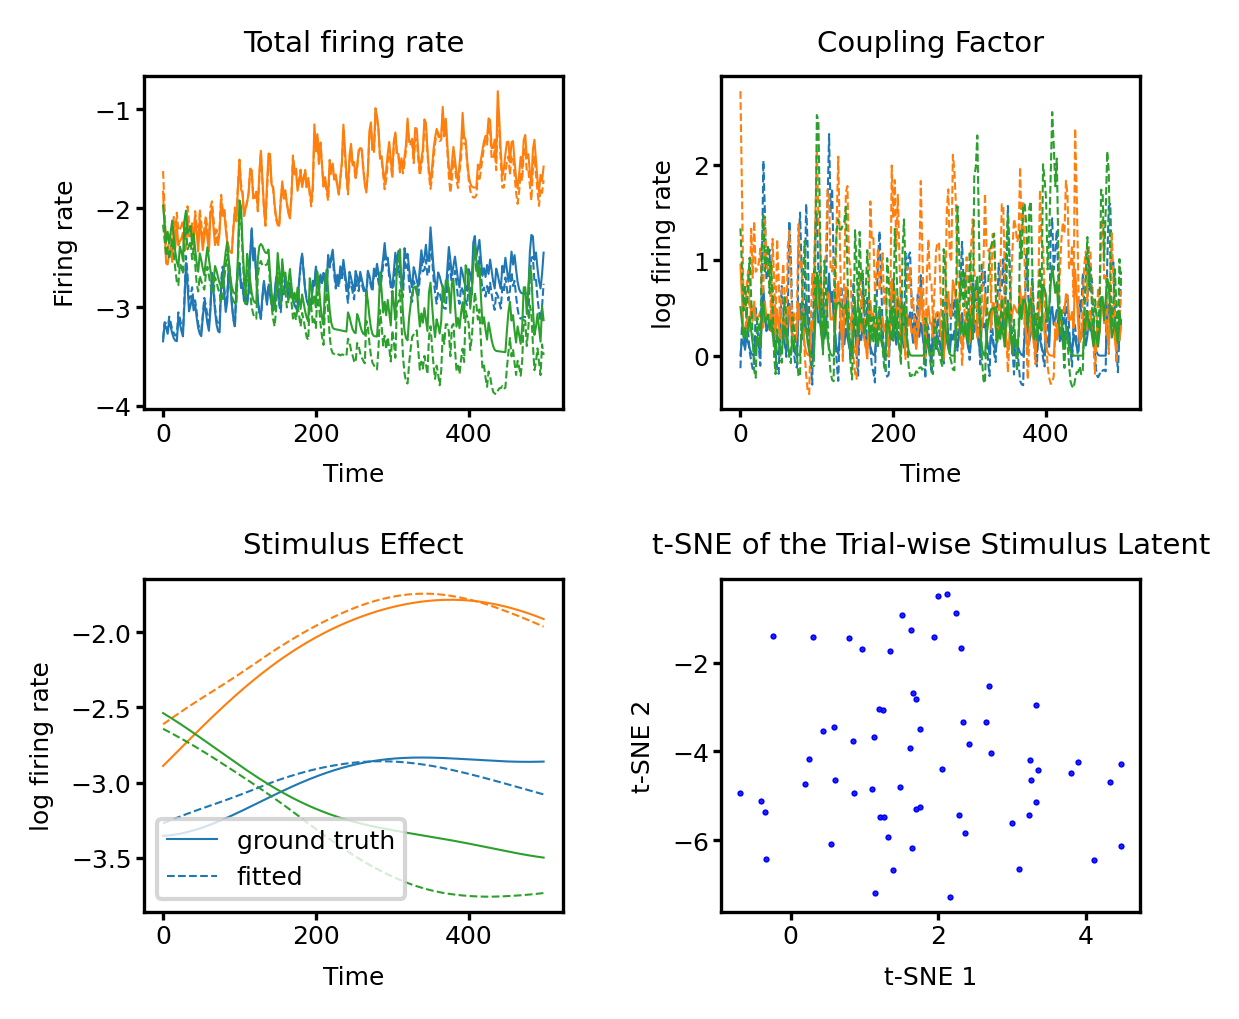

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.manifold import TSNE

local_trial_indices = np.arange(0, 3)
neuron_idx = 55

firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices = trainer.predict(
    dataset='test',
    batch_indices=[0],
    include_stimulus=True,
    include_coupling=True,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=True,
)

# Create a 2x2 subplot figure
utils.use_pdf_plot()
fig, axes = plt.subplots(2, 2, figsize=(4, 3.5), dpi=300)

# Plot total firing rate
xx = np.arange(firing_rate_test.shape[0]) * 2  # Adjusted x-axis
for trial_idx in local_trial_indices:
    # Plot ground truth
    axes[0, 0].plot(
        xx,
        log_firing_rate_rcd[gt_neuron_params['npadding']:, neuron_idx, trial_indices[trial_idx]],
        linestyle='-',
        color=f'C{trial_idx}',  # Match color with predicted
        label=f'ground truth',
        lw=0.5,
    )
    # Plot predicted
    axes[0, 0].plot(
        xx,
        firing_rate_test[:, neuron_idx, trial_idx].cpu().numpy(),
        linestyle='--',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )
axes[0, 0].set_title('Total firing rate')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Firing rate')

# Plot coupling factor
for trial_idx in local_trial_indices:
    # Plot ground truth
    axes[0, 1].plot(
        xx,
        factor_coupling[gt_neuron_params['npadding']:, 0, trial_indices[trial_idx]],
        linestyle='-',
        color=f'C{trial_idx}',  # Match color with predicted
        label=f'ground truth',
        lw=0.5,
    )
    # Plot predicted
    axes[0, 1].plot(
        xx,
        trainer.model.coupling_outputs_subspace[0][1][trial_idx, 0, :].cpu().numpy(),
        linestyle='--',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )

axes[0, 1].set_title('Coupling Factor')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('log firing rate')

# Plot stimulus effect
for trial_idx in local_trial_indices:
    # Plot ground truth
    axes[1, 0].plot(
        xx,
        baseline_mat[gt_neuron_params['npadding']:, neuron_idx, trial_indices[trial_idx]],
        linestyle='-',
        color=f'C{trial_idx}',  # Match color with predicted
        label=f'ground truth',
        lw=0.5,
    )
    # Plot predicted
    axes[1, 0].plot(
        xx,
        trainer.model.firing_rates_stimulus[trial_idx, neuron_idx, :].cpu().numpy(),
        linestyle='--',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )
    

axes[1, 0].set_title('Stimulus Effect')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('log firing rate')
# Add legend for the first pair only
handles, labels = axes[1, 0].get_legend_handles_labels()
if len(handles) >= 2:  # Make sure we have at least one pair
    # Keep only first ground truth and fitted pair
    axes[1, 0].legend([handles[0], handles[1]], ['ground truth', 'fitted'])


# Plot t-SNE in the last subplot
sti_mu_test_np = sti_mu_test.cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test

if sti_mu_test_np.shape[1] <= 2:
    print(f"Only one dimension")
elif np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    for i in range(len(sti_mu_test_tsne)):
        axes[1, 1].scatter(
            sti_mu_test_tsne[i, 0],
            sti_mu_test_tsne[i, 1],
            marker='.',
            s=1,
            color='b'
        )
    axes[1, 1].set_title('t-SNE of the Trial-wise Stimulus Latent')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
else:
    print(
        f"Stimulus latent is not varying across trials: "
        f"{sti_mu_test_np.std(axis=0).mean()}"
    )

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne.pdf', bbox_inches='tight', dpi=300)


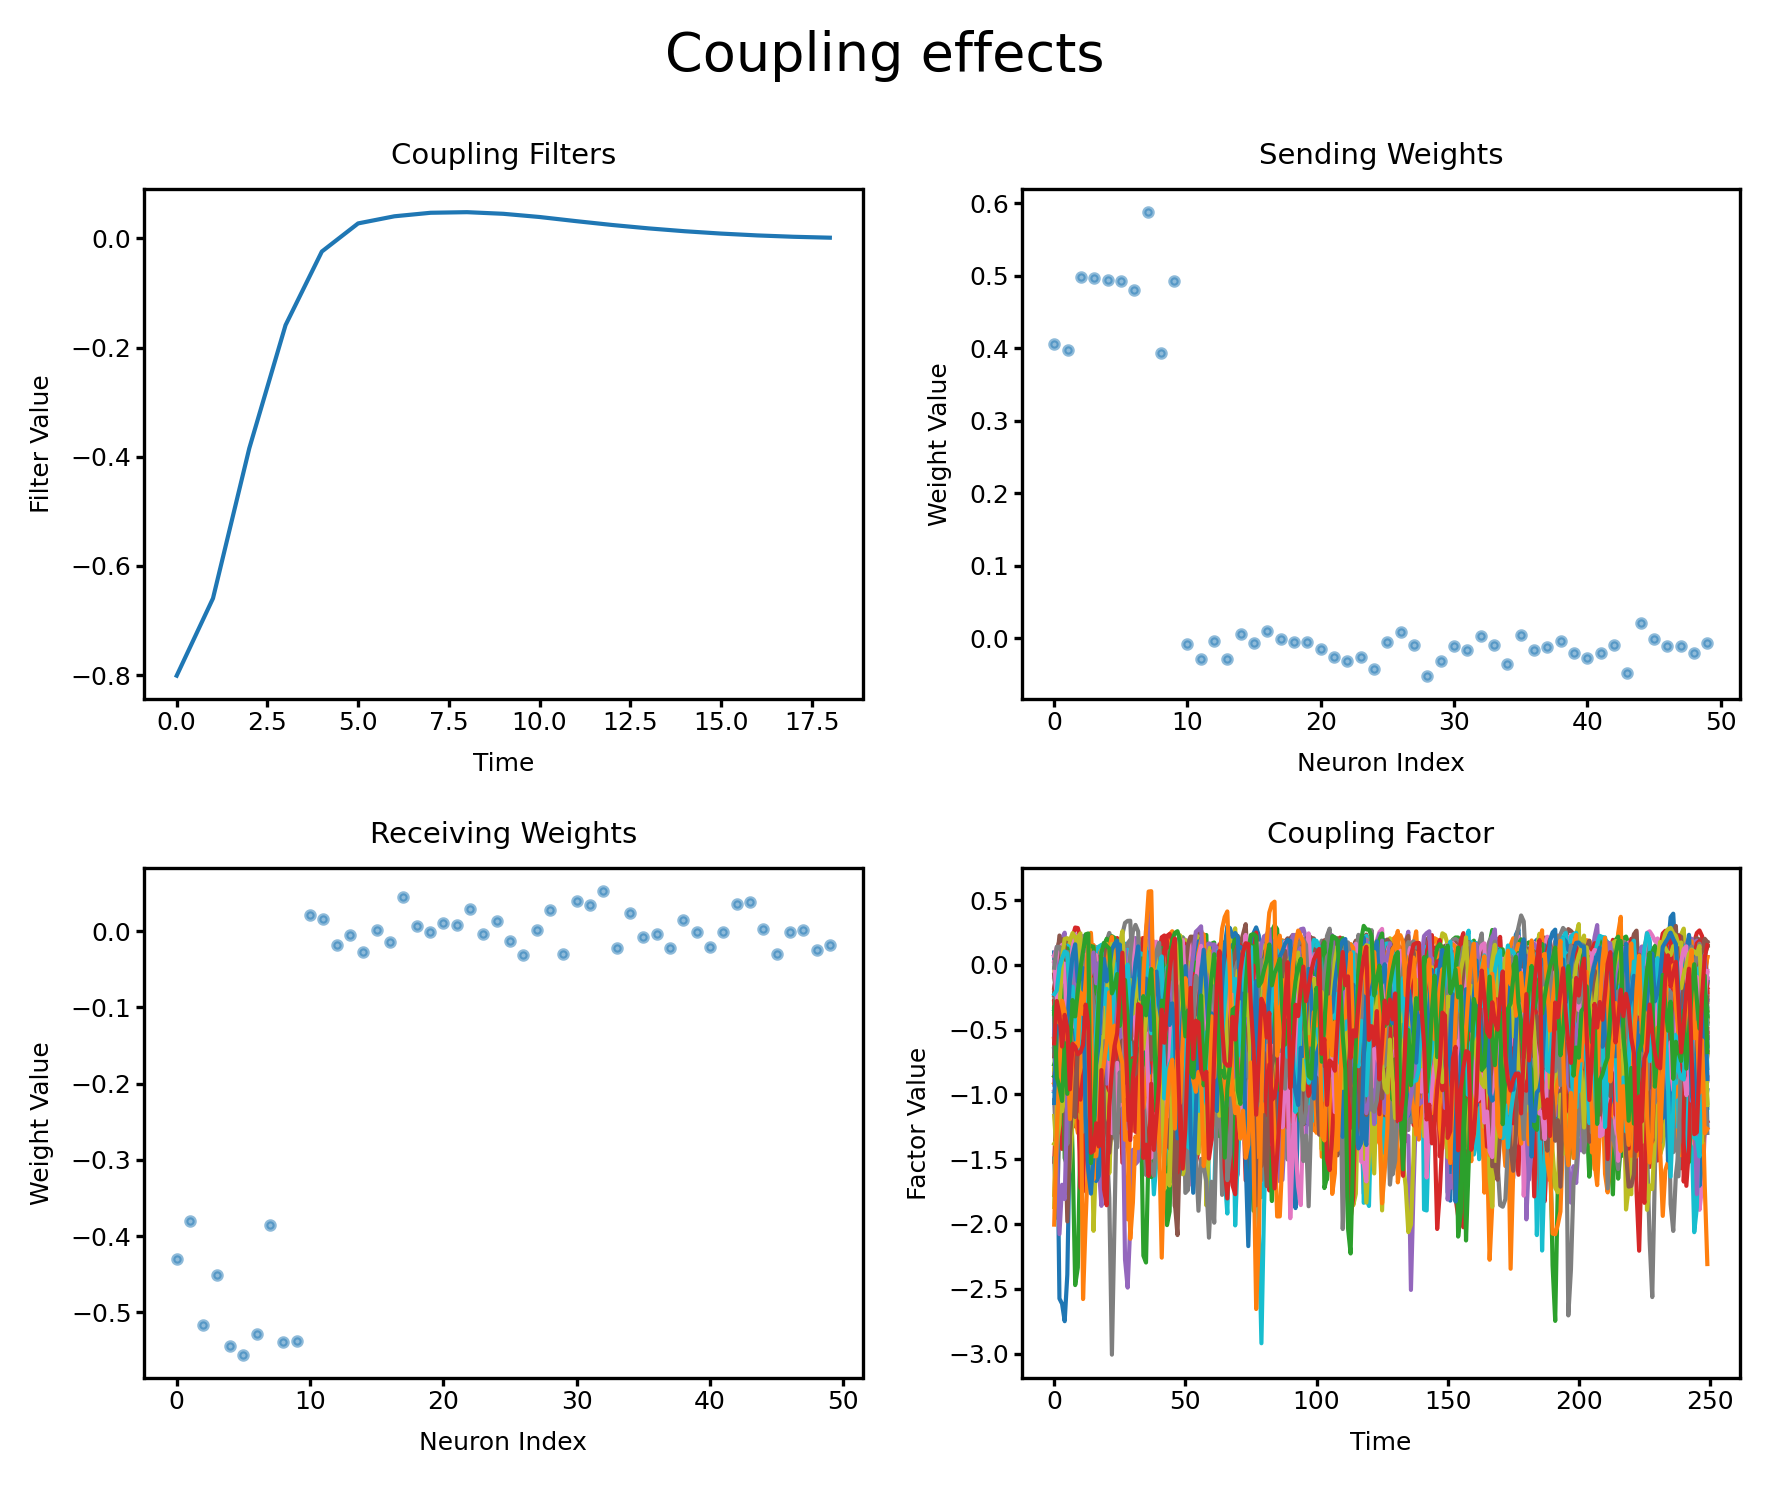

In [195]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Coupling effects', 
    fontsize=13
)

# Plot coupling filters
axes[0,0].plot(trainer.model.coupling_filters_dict["0"][0][1].cpu().numpy())
axes[0,0].set_title('Coupling Filters')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Filter Value')

# Plot sending weights 
axes[0,1].plot(trainer.model.cp_weight_sending_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[0,1].set_title('Sending Weights')
axes[0,1].set_xlabel('Neuron Index')
axes[0,1].set_ylabel('Weight Value')

# Plot receiving weights
axes[1,0].plot(trainer.model.cp_weight_receiving_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1,0].set_title('Receiving Weights')
axes[1,0].set_xlabel('Neuron Index') 
axes[1,0].set_ylabel('Weight Value')

# Plot coupling factor
axes[1,1].plot(trainer.model.coupling_outputs_subspace[0][1].detach().cpu().numpy()[:,0,:].T)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Factor Value')

plt.tight_layout()


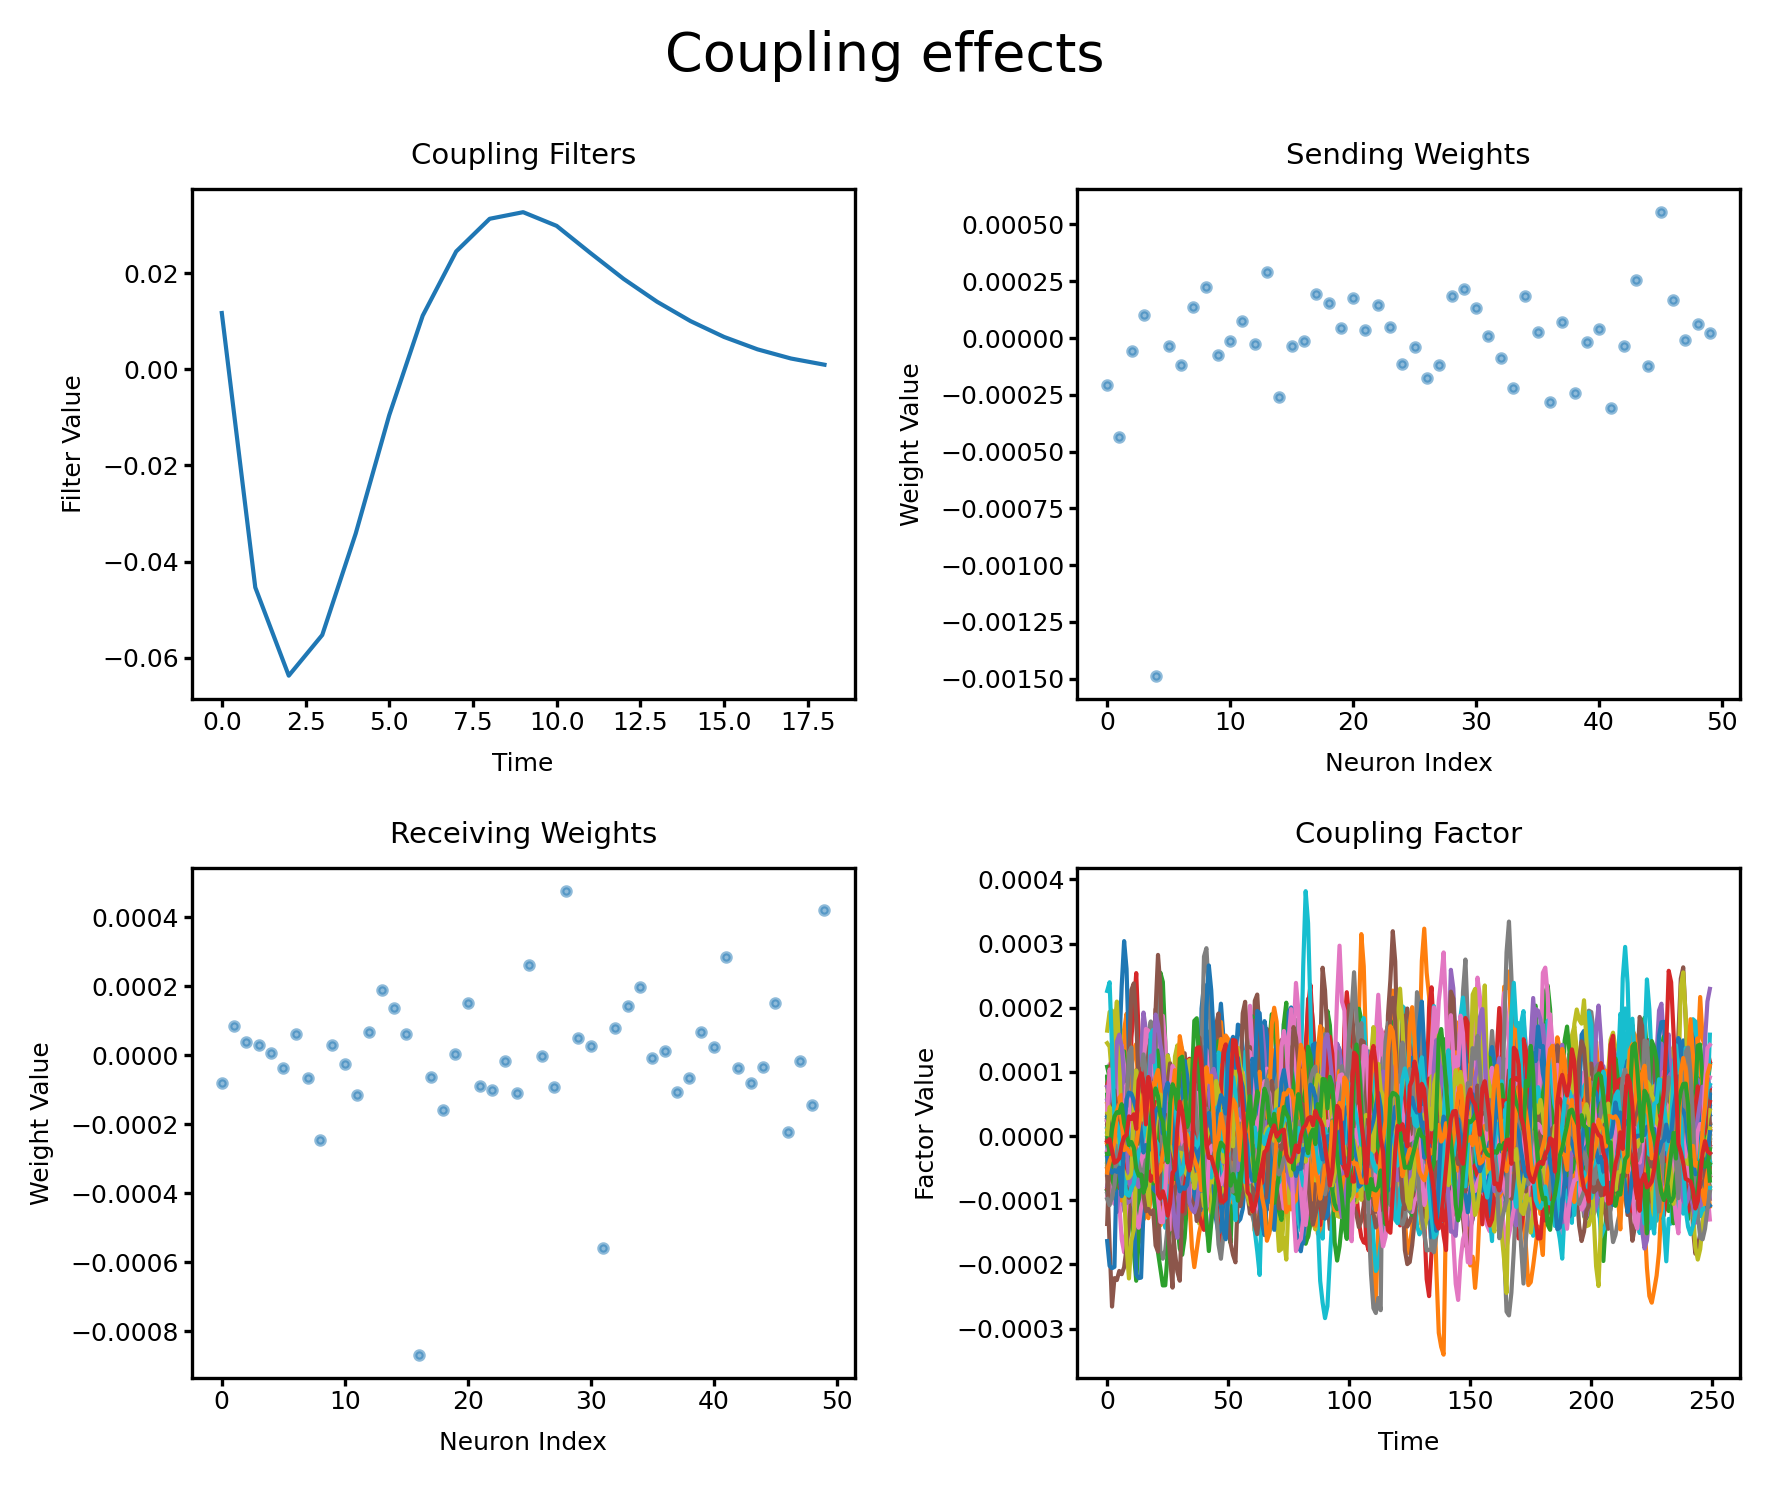

In [196]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Coupling effects', 
    fontsize=13
)

# Plot coupling filters
axes[0,0].plot(trainer.model.coupling_filters_dict["0"][1][0].cpu().numpy())
axes[0,0].set_title('Coupling Filters')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Filter Value')

# Plot sending weights 
axes[0,1].plot(trainer.model.cp_weight_sending_dict["0"][1][0].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[0,1].set_title('Sending Weights')
axes[0,1].set_xlabel('Neuron Index')
axes[0,1].set_ylabel('Weight Value')

# Plot receiving weights
axes[1,0].plot(trainer.model.cp_weight_receiving_dict["0"][1][0].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1,0].set_title('Receiving Weights')
axes[1,0].set_xlabel('Neuron Index') 
axes[1,0].set_ylabel('Weight Value')

# Plot coupling factor
axes[1,1].plot(trainer.model.coupling_outputs_subspace[1][0].detach().cpu().numpy()[:,0,:].T)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Factor Value')

plt.tight_layout()
